In [56]:
# Imports
import json, re, numpy as np, numpy.linalg as nplin, matplotlib.pyplot as plt, string, operator, sys
from bs4 import BeautifulSoup
from __future__ import division
from time import time
from operator import itemgetter
from Pycluster import kcluster
%matplotlib inline

# Am I working on AWS?
AWS = False

# Get the onlineldavb module. 
# Originally downloaded from http://www.cs.princeton.edu/~blei/downloads/onlineldavb.tar
if not AWS:
    sys.path.append("/home/aaron/uchi.course.work/stat376/onlineldavb/")
import onlineldavb, onlinewikipedia, printtopics, wikirandom

# Check Spark is working
print sc 

In [2]:
# Download the test data set
!wget http://s3.amazonaws.com/stat-37601/wiki.json
!mv wiki.json data/ 

--2015-05-07 23:50:50--  http://s3.amazonaws.com/stat-37601/wiki.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.14.128
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.14.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5758958 (5.5M) [application/octet-stream]
Saving to: ‘wiki.json’

100%[======================================>] 5,758,958   3.48MB/s   in 1.6s   

2015-05-07 23:50:51 (3.48 MB/s) - ‘wiki.json’ saved [5758958/5758958]



In [3]:
# load data
if AWS:
    rawWiki = "s3n://stat-37601/wiki.json"
else:
    rawWiki = "data/wiki.json"

testWiki = sc.textFile(rawWiki).map(lambda x: json.loads(x))

#### Fit the topic model on 12,800 random wikipedia articles

In [4]:
# This section is largely stolen from "onlinewikipedia.py", part of the onlineldavb package
# I just wanted to be able to parameterize it and get output within python

# The number of documents to analyze each iteration
batchsize = 64
# The total number of documents in Wikipedia
D = 4865783              # as of 5/9/2015
# The number of topics
K = 100
# How many batches of documents to look at
documentstoanalyze = 200

# Our vocabulary
vocab = file('onlineldavb/dictnostops.txt').readlines()
W = len(vocab)

# Initialize the algorithm with alpha=1/K, eta=1/K, tau_0=1024, kappa=0.7
olda = onlineldavb.OnlineLDA(vocab, K, D, 1./K, 1./K, 1024., 0.7)
# Run until we've seen D documents. (Feel free to interrupt *much* sooner than this.)
for iteration in range(0, documentstoanalyze):
    # Download some articles
    (docset, articlenames) = wikirandom.get_random_wikipedia_articles(batchsize)
    # Give them to online LDA
    (gamma, bound) = olda.update_lambda(docset)
    # Compute an estimate of held-out perplexity
    (wordids, wordcts) = onlineldavb.parse_doc_list(docset, olda._vocab)
    perwordbound = bound * len(docset) / (D * sum(map(sum, wordcts)))
    print '%d:  rho_t = %f,  held-out perplexity estimate = %f' % (iteration, olda._rhot, np.exp(-perwordbound))
    print '%d out of %d articles analyzed' % ((iteration+1)*batchsize, documentstoanalyze*batchsize)

downloaded 0/64 articles...
downloaded Ann_Mary_Newton. parsing...
downloaded Alert,_Ohio. parsing...
downloaded John_Mossop. parsing...
downloaded Kim_Do-hoon. parsing...
downloaded Khabezsky_District. parsing...
downloaded European_College_of_Neuropsychopharmacology. parsing...
downloaded Long_Walk_to_Forever_(short_film). parsing...
downloaded Didem_Sar%C4%B1ca. parsing...
downloaded 8/64 articles...
downloaded Spooky_(New_Order_song). parsing...
downloaded Yan%27an_faction. parsing...
downloaded Olli_M%C3%A4%C3%A4tt%C3%A4. parsing...
downloaded Saint_Peter_of_Alcantara_Parish_Church. parsing...
downloaded Henry_River. parsing...
downloaded Atom_Shukugawa. parsing...
downloaded Nancy_Eiesland. parsing...
downloaded Haruna_Asami. parsing...
downloaded 16/64 articles...
downloaded Lightner_double. parsing...
downloaded IL_Brodd. parsing...
downloaded Welshpool,_Western_Australia. parsing...
downloaded Rosendo_%C3%81lvarez_Gast%C3%B3n. parsing...
downloaded Unfriended. parsing...
downl

#### Use model to make predictions on test data set

In [5]:
def parseWiki(article):
    """
    Turns the json object given for the test wikipedia articles, parses the html of the body, and returns
    the cleanted text and title as a tuple.
    
    Mostly lifted from wikirandom.py in the onlineldavb package
    This could probably be done easier/better with BeautifulSoup, but its best to maintain consistancy 
    (this is what the model did when fitting)
    """
    all = article['body']
    all = re.search(r'<text.*?>(.*)</text', all, flags=re.DOTALL).group(1)
    all = re.sub(r'\n', ' ', all)
    all = re.sub(r'\{\{.*?\}\}', r'', all)
    all = re.sub(r'\[\[Category:.*', '', all)
    all = re.sub(r'==\s*[Ss]ource\s*==.*', '', all)
    all = re.sub(r'==\s*[Rr]eferences\s*==.*', '', all)
    all = re.sub(r'==\s*[Ee]xternal [Ll]inks\s*==.*', '', all)
    all = re.sub(r'==\s*[Ee]xternal [Ll]inks and [Rr]eferences==\s*', '', all)
    all = re.sub(r'==\s*[Ss]ee [Aa]lso\s*==.*', '', all)
    all = re.sub(r'http://[^\s]*', '', all)
    all = re.sub(r'\[\[Image:.*?\]\]', '', all)
    all = re.sub(r'Image:.*?\|', '', all)
    all = re.sub(r'\[\[.*?\|*([^\|]*?)\]\]', r'\1', all)
    all = re.sub(r'\&lt;.*?&gt;', '', all)

    return (article['title'], all)


In [24]:
# Generate the gamma vectors. 
# For some reason, I could not get this to work with spark; I even tried building a method into the onlineldvab 
# object to run do_e_step over an rdd. In any event, with 56 items, spark is probably slower anyway.
titles, texts = zip(*testWiki.map(parseWiki).collect())
gammas = map(lambda body: olda.do_e_step([body])[0],texts)
gammas = map(lambda gamma: gamma/np.sum(gamma), gammas)

#### Find similar articles in test data
I performed k-medians clustering based on the posterior distribution to match similar articles, since the L1 norm generally performs nicely as a similarlity measure when one has sparsity.

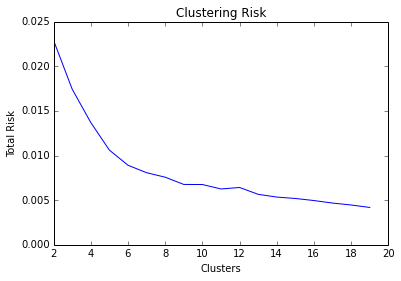

In [84]:
# Make a matrix of the gammas
gammaMat = np.vstack(gammas)

# Take a look at the clustering risk for various numbers of clusters
ks = range(2,20)
clusterings = map(lambda n: kcluster(gammaMat,nclusters=n,npass=100,method='m'),ks)
errors = [er for (cen,er,nfound) in clusterings]

plt.plot(ks,errors)
plt.title('Clustering Risk')
plt.xlabel('Clusters')
plt.ylabel('Total Risk')

We seem to have something of an elbow at six clusters, so that would be the one I went with if I didn't have any more information. However, checking forward, I think eight is actually the appropriate number.

Below, I have printed out which article went into which cluster. As well, the top three topics for each of the centers of the clusters and the words which are most skewed towards those topics are printed out.

In [246]:
# Idenitfy topics by words which are most skewed towards one of the topics
reverseVocab = dict(zip(olda._vocab.values(),olda._vocab.keys()))              # Lets us look up word via index
lookUpFunc = np.vectorize(lambda index: reverseVocab[index],otypes=[np.str])   # This function looks up words over a numpy array
topIndex = np.argsort(olda._lambda/np.sum(olda._lambda,axis=0),axis=1)[:,:-9:-1]  # Pick out the index most skewed towards a particular topic
topWords = lookUpFunc(topIndex)                                                # Translate index into words

# Lets take a look at these clusters
clusterids = clusterings[6][0]
clusterInfo =[]
for c in range(len(np.unique(clusterids))):
    clusterInfo.append({})
    clusterInfo[c]['titles'] = np.array(titles)[clusterids==c]
    clusterInfo[c]['center'] = np.median(gammaMat[clusterids==c,:],0)
    clusterInfo[c]['topTopics'] = np.argsort(clusterInfo[c]['center'])[-3:]
    clusterInfo[c]['topWeights'] = clusterInfo[c]['center'][clusterInfo[c]['topTopics']]
    
    print 'CLUSTER %d' % (c+1)
    print '\t Matched Articles: ' + ', '.join(['%s' % w for w in clusterInfo[c]['titles']])
    for t in range(1,4):
        print '\t Topic %d (weight %.2f): '% (clusterInfo[c]['topTopics'][-t],clusterInfo[c]['topWeights'][-t]) +  ', '.join(['%s' % w for w in topWords[clusterInfo[c]['topTopics'][-t],:]])
    print '\t'

CLUSTER 1
	 Matched Articles: Matlab, Beatles, The_who
	 Topic 99 (weight 0.01): angel, containing, serene, interpretation, double, depths, tan, jesus
	 Topic 36 (weight 0.01): revolt, ruler, soldiers, fortress, conquer, retreat, retreated, escaped
	 Topic 26 (weight 0.01): cathedral, pope, cardinal, bishops, profession, appointed, saxon, buried
	
CLUSTER 2
	 Matched Articles: David_Beckham, Diego_Maradona, Lionel_Messi
	 Topic 7 (weight 0.19): leagues, season, injury, win, passer, beating, beat, finished
	 Topic 82 (weight 0.17): match, cups, coach, cup, friendly, fairest, manager, card
	 Topic 55 (weight 0.07): clubs, goals, loan, premier, league, substitute, club, honours
	
CLUSTER 3
	 Matched Articles: Python_(programming_language), Java_(programming_language), Ruby_(programming_language), C_(programming_language), C_Sharp_(programming_language), Perl, JavaScript, R_(programming_language), Haskell_(programming_language)
	 Topic 29 (weight 0.11): democratic, jewish, social, readable

Besides the first cluster, we have really simliar articles in each cluster (basketball players, rock bands, countries, ect.). What happened with the first cluster is that these are all page redirects; For instance, "The_who" just has a link to the article "The_Who", and no text. 

A bunch of the topics match very logically with the cluster. For instance, topic 7, which is some kind of sports topic, is the top match for the basketball players, swimmers, and soccer players. Topic 11 seems to be an economic topic, and its logically a high match for both the countries and the banks. The bands cluster has three highly weighted, but slightly different, music topics. 

The cluster I find fascinating though is the programing language cluster. All the programing languages got matched together, but the topics are suprising. The highest weighted one is the polticial movement topic (29), which programing languges share with the countries. Then, the second topic seems to be a medical topic (95). Only the final one (21), which is a mathematics topic (I checked a little further down) is what I would have expected. My guess is that the high influence of the political movement topic is due to the articles on programing languages talking a lot about the philosphies and communities that guide the languages. I can't really explain the medical topic, besides maybe a common theme of technology.

#### Sidenote 
I was curious about "jewish" skewing so heavily towards the political movement topic, so I compared it to "jew". I calculated the difference between the skew of "jew" towards a topic and "jewish" to a topic, picking out the topics with the biggest difference. It seems "Jew" skews a lot to the religion, nationality, and war topics, while "Jewish" is skewed towards political movements. Fascinating.

In [242]:
skewness = olda._lambda/np.sum(olda._lambda,axis=0)
for i,v in enumerate(scaled[:,olda._vocab['jew']]-scaled[:,olda._vocab['jewish']]):
    if np.abs(v)>.1: print '\t Topic %d (%.2f): ' % (i,v)  +  ', '.join(['%s' % w for w in topWords[i,:]])

	 Topic 4 (0.16): sweden, brussels, belgium, israel, netherlands, och, switzerland, italy
	 Topic 24 (0.20): temple, temples, coin, homer, romans, prosperous, centuries, elders
	 Topic 29 (-0.81): democratic, jewish, social, readable, movement, philosophical, political, ideals
	 Topic 36 (0.13): revolt, ruler, soldiers, fortress, conquer, retreat, retreated, escaped
